In [1]:
import pandas as pd


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [39]:
df = pd.read_csv('data/combined_data_binance_ethusdc.csv')

df = df.drop(['Unnamed: 6', 'is_buyer_maker'], axis=1)
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time').sort_index()

df['prev_price'] = df['price'].shift(1)

def determine_order_type(row):
    if pd.isna(row['prev_price']):
        return None
    return 'buy' if row['price'] > row['prev_price'] else 'sell'


def adjust_quantity(row):
    if row['order_type'] == 'sell':
        return -row['qty']  # Make the quantity negative for sell orders
    else:
        return row['qty']  # Keep the quantity as is for buy orders
    
    
df['order_type']   = df.apply(determine_order_type, axis=1)
df['adjusted_qty'] = df.apply(adjust_quantity, axis=1)

df.drop(columns=['prev_price'], inplace=True)
df


,trade ID,price,qty,base_qty,order_type,adjusted_qty
time,,,,,,
2023-03-12 06:30:00.000,29221034,1482.62,0.0068,10.081816,None,0.0068
2023-03-12 06:30:01.361,29221035,1677.81,0.3063,513.913203,buy,0.3063
2023-03-12 06:30:36.552,29221036,1495.02,0.0078,11.661156,sell,-0.0078
2023-03-12 06:30:36.552,29221037,1495.01,0.1265,189.118765,sell,-0.1265
2023-03-12 06:30:36.552,29221038,1495.00,0.1717,256.691500,sell,-0.1717
...,...,...,...,...,...,...
2024-01-31 23:58:46.318,33951706,2281.43,0.1201,273.999743,sell,-0.1201
2024-01-31 23:58:46.380,33951707,2281.43,0.2191,499.861313,sell,-0.2191
2024-01-31 23:59:01.498,33951708,2281.49,0.0365,83.274385,buy,0.0365


In [40]:
ohlc_seconds = df['price'].resample('S').ohlc()
ohlc_seconds

,open,high,low,close
time,,,,
2023-03-12 06:30:00,1482.62,1482.62,1482.62,1482.62
2023-03-12 06:30:01,1677.81,1677.81,1677.81,1677.81
2023-03-12 06:30:02,NaN,NaN,NaN,NaN
2023-03-12 06:30:03,NaN,NaN,NaN,NaN
2023-03-12 06:30:04,NaN,NaN,NaN,NaN
...,...,...,...,...
2024-01-31 23:59:22,NaN,NaN,NaN,NaN
2024-01-31 23:59:23,NaN,NaN,NaN,NaN
2024-01-31 23:59:24,NaN,NaN,NaN,NaN


In [48]:
# Generate a full datetime range from start to end of your dataset, with 1-minute frequency
full_range = pd.date_range(start=ohlc_seconds.index.min(), end=ohlc_seconds.index.max(), freq='S')

# Identify missing minutes
missing_minutes = full_range.difference(ohlc_seconds.dropna().index)

print("Missing minutes:")
print(len(missing_minutes))
print(missing_minutes)

Missing minutes:
26120503
DatetimeIndex(['2023-03-12 06:30:02', '2023-03-12 06:30:03',
               '2023-03-12 06:30:04', '2023-03-12 06:30:05',
               '2023-03-12 06:30:06', '2023-03-12 06:30:07',
               '2023-03-12 06:30:08', '2023-03-12 06:30:09',
               '2023-03-12 06:30:10', '2023-03-12 06:30:11',
               ...
               '2024-01-31 23:59:16', '2024-01-31 23:59:17',
               '2024-01-31 23:59:18', '2024-01-31 23:59:19',
               '2024-01-31 23:59:20', '2024-01-31 23:59:21',
               '2024-01-31 23:59:22', '2024-01-31 23:59:23',
               '2024-01-31 23:59:24', '2024-01-31 23:59:25'],
              dtype='datetime64[ns]', length=26120503, freq=None)


In [41]:
ohlc_minutes = df['price'].resample('T').ohlc()
ohlc_minutes

# Generate a full datetime range from start to end of your dataset, with 1-minute frequency
full_range = pd.date_range(start=ohlc_minutes.index.min(), end=ohlc_minutes.index.max(), freq='T')

# Identify missing minutes
missing_minutes = full_range.difference(ohlc_minutes.dropna().index)

print("Missing minutes:")
print(len(missing_minutes))
print(missing_minutes)

,open,high,low,close
time,,,,
2023-03-12 06:30:00,1482.62,1677.81,1482.62,1495.00
2023-03-12 06:31:00,NaN,NaN,NaN,NaN
2023-03-12 06:32:00,NaN,NaN,NaN,NaN
2023-03-12 06:33:00,NaN,NaN,NaN,NaN
2023-03-12 06:34:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2024-01-31 23:55:00,2283.40,2283.40,2282.47,2282.53
2024-01-31 23:56:00,2282.53,2282.79,2282.28,2282.79
2024-01-31 23:57:00,2282.69,2282.69,2282.57,2282.57


<Axes: xlabel='time'>

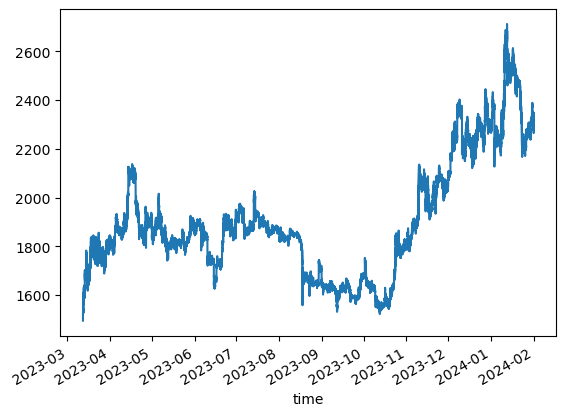

In [37]:
ohlc_minutes.dropna().close.plot()

In [117]:
data = pd.read_pickle('Merged_CEX_DEX_v2_p1.pkl')
data.head()

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,price_dex,tcost_usd,time,time_dex,price_cex,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2280.878682,13.245562,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2280.878682,10.235724,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2281.106770,6.410172,2024-01-01 00:00:47,2024-01-01 00:00:47,2282.69,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,19.908921
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2281.106770,6.936970,2024-01-01 00:00:59,2024-01-01 00:00:59,2282.69,2024-01-01 00:00:35.850,1.583230,3.789096,-0.532617,20.441538
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2281.106770,88.043187,2024-01-01 00:01:23,2024-01-01 00:01:23,2281.64,2024-01-01 00:01:08.214,0.533230,4.322326,-0.039934,20.481472


In [141]:
import numpy as np

def zscore(series):
    return (series - series.mean()) / series.std()

data['LVR_nbtoken'] = data['LVR']/data['price_dex']
data['LVR_pnl_percent'] = (np.abs(data['LVR_clean']*data['amountUSD'])-data['tcost_usd'])*100/data['amountUSD']
data['LVR_zscore'] = zscore(data['LVR'])

In [142]:
# 'origin','sender'
data[['LVR_pnl_percent', 'origin']].groupby('origin').sum()

,LVR_pnl_percent
origin,
0x0000000000211b7cdd33049a9f1985013babb784,227.933460
0x000000000026a1f577dbf53aaf2c82be36dad52e,158.115101
0x00000000006753b3acb0d6f57a11abce4cffc049,167.642743
0x000000000092214e86d0c37795c80807d0ab14dc,188.280430
0x0000000000b3b15e53730ee3042f8b12fc659535,8.786646
...,...
0xffeccfec9c710f3d51876d0c4a0e7920fd4856d8,156.178062
0xfff2c305b277879cc2e9c273632e9523ed99cdde,219.482007
0xfffa84476428be3370be2802b6e0fad24d9fe833,74.419108


array([[<Axes: title={'center': 'LVR_pnl_percent'}>]], dtype=object)

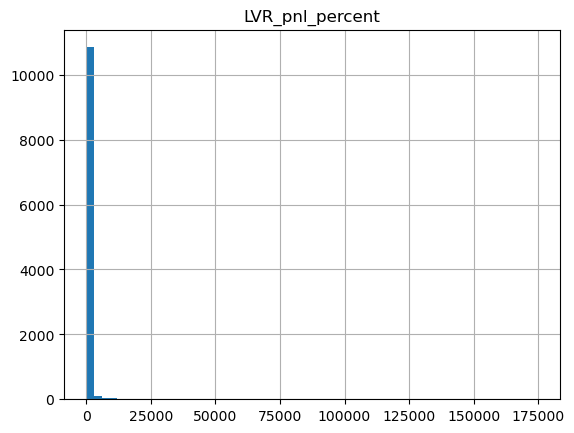

In [131]:
tmp = (data[['LVR_pnl_percent', 'origin']].groupby('origin').sum()>100).reset_index()
abritrageur_address_list = tmp[tmp['LVR_pnl_percent'] == True].origin.values
len(abritrageur_address_list)
filtered_data = data[data['origin'].isin(abritrageur_address_list)]
filtered_data[['LVR_pnl_percent', 'origin']].groupby('origin').sum().hist(bins=60)

In [132]:
data[['LVR_zscore', 'origin']]

,LVR_zscore,origin
0,-0.012213,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84
1,-0.010061,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503
2,-0.025702,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0
3,-0.010458,0xc10527cdbc055b7f9a8a4ad765b287190c861c51
4,-0.010011,0xf468072ca8f81e11655c252a37317e814b24872b
...,...,...
59995,-0.011884,0xca74f404e0c7bfa35b13b511097df966d5a65597
59996,-0.013343,0x475d2c6f6a46a83d1781e61500d1c540f85fd721
59997,-0.014075,0xeef68d213fbbf6f01235a6c1318f82a1692c01de
59998,0.068279,0xe4e968b3abe7123f18b318e8ad17ce3826b5cff6


In [133]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

tmp = (data[['LVR_pnl_percent', 'sender']].groupby('sender').sum()>100).reset_index()
abritrageur_address_list = tmp[tmp['LVR_pnl_percent'] == True].sender.values
print(len(abritrageur_address_list))
filtered_data = data[data['sender'].isin(abritrageur_address_list)]
t = data[['LVR_pnl_percent', 'sender']].groupby('sender').sum().apply(lambda x : sigmoid(x))

201


/Users/armandmorin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [134]:
data[['LVR_pnl_percent', 'sender']].groupby('sender').sum()
data[['LVR_pnl_percent', 'origin']].groupby('origin').sum()

,LVR_pnl_percent
origin,
0x0000000000211b7cdd33049a9f1985013babb784,227.933460
0x000000000026a1f577dbf53aaf2c82be36dad52e,158.115101
0x00000000006753b3acb0d6f57a11abce4cffc049,167.642743
0x000000000092214e86d0c37795c80807d0ab14dc,188.280430
0x0000000000b3b15e53730ee3042f8b12fc659535,8.786646
...,...
0xffeccfec9c710f3d51876d0c4a0e7920fd4856d8,156.178062
0xfff2c305b277879cc2e9c273632e9523ed99cdde,219.482007
0xfffa84476428be3370be2802b6e0fad24d9fe833,74.419108


In [160]:
# methodology:
# Take a rolli,ng windows of the past 1 million tx for instance
# Perform all the signle trades analysis, in term of pnl anf LVR percent
# Aggregate the metrics to get the trader perfs 
# Charge the fee per trader

import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def fee_pnl(LVR_pnl_percent):
    # output is in 100%
    coef = 1
    return sigmoid(LVR_pnl_percent / 250) * coef

def fee_base(LVR_zscore):
    # output is in 100%
    base_pool_fee = 0.05
    coef = 1.03
    return coef * sigmoid(base_pool_fee + LVR_zscore * 0.03)

agg_sender = data[['LVR_pnl_percent', 'LVR_zscore', 'sender']].groupby('sender').sum()
agg_origin = data[['LVR_pnl_percent', 'LVR_zscore', 'origin']].groupby('origin').sum()
agg_recipient = data[['LVR_pnl_percent', 'LVR_zscore', 'recipient']].groupby('recipient').sum()

dico_percent = {}
dico_zscore = {}

for df in [agg_sender, agg_origin, agg_recipient]:
    for address, lvr_percent, lvr_zscore in zip(df.index, df['LVR_pnl_percent'], df['LVR_zscore']):
        if address in dico_percent:
            dico_percent[address] += lvr_percent
            dico_zscore[address] += lvr_zscore
        else:
            dico_percent[address] = lvr_percent
            dico_zscore[address] = lvr_zscore


# filter addresses trading with positive LVR return 
dic_base_fee = {address: fee_base(LVR_zscore) for address, LVR_zscore in dico_zscore.items() if LVR_zscore > 0}

dic_fee       = {address: fee_pnl(LVR_pnl_percent) for address, LVR_pnl_percent in dico_percent.items() if LVR_pnl_percent > 0 }

merged_dict = {key: dic_fee.get(key, 0) + dic_base_fee.get(key, 0) for key in set(dic_fee) | set(dic_base_fee)}

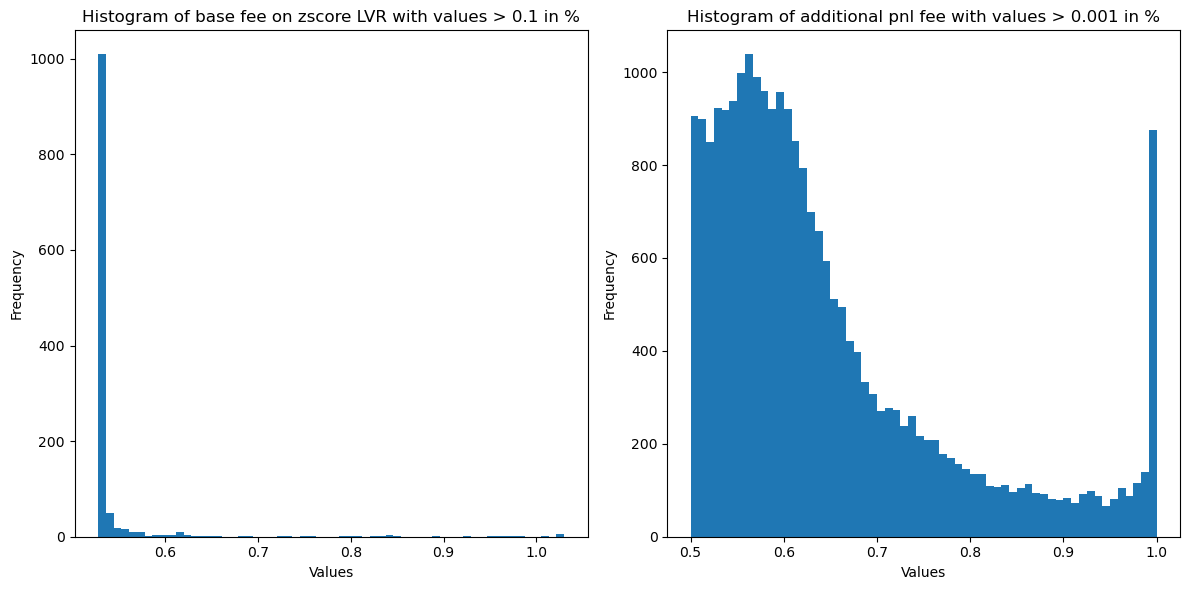

In [161]:
import matplotlib.pyplot as plt

# Filter values greater than threshold in %
threshold_base = 0.1
threshold_fees = 0.001
filtered_base_values = [value for value in dic_base_fee.values() if value > threshold_base]
filtered_fee_values = [value for value in dic_fee.values() if value > threshold_fees]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(filtered_base_values, bins=60)
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Histogram of base fee on zscore LVR with values > {threshold_base} in %')

ax2.hist(filtered_fee_values, bins=60)
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Histogram of additional pnl fee with values > {threshold_fees} in %')

plt.tight_layout()
plt.show()


In [154]:
please.reset_index().rename(columns={'index': 'address'}).sort_values(by='fees', ascending=False)

,address,address,fees
0,6979,0xe592427a0aece92de3edee1f18e0157c05861564,1.530000
1,12553,0x6b75d8af000000e20b7a7ddf000ba900b4009a80,1.529954
2,4809,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.529854
3,2877,0xa43a3c6bcc913285100567b9706d6c39fb2a3583,1.525377
4,6170,0xae2fc483527b8ef99eb5d9b44875f005ba1fae13,1.523296
...,...,...,...
13227,5777,0xd3861dd2310ba0ac43a89272d64e0245fb8cc3ce,0.250000
13228,12319,0xb4b21c0b11a58d7667118c9cb51d546b52d624b4,0.250000
13229,2339,0xe1c19d9e102c9da6a346b5cab627f9d9840d4efa,0.250000
13230,8671,0x4dab6da6846f82c93354ae90f8b56993efb1e5b1,0.250000


In [155]:
please = pd.DataFrame.from_dict(merged_dict, orient='index', columns=['fees'])
please = please.reset_index().rename(columns={'index': 'address'}).sort_values(by='fees', ascending=False)

merged_data = data.merge(please.rename(columns={'fees' : 'f1'}), left_on='sender', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f2'}), left_on='origin', how='left', right_on='address')
merged_data = merged_data.merge(please.rename(columns={'fees' : 'f3'}), left_on='recipient', how='left', right_on='address')

merged_data[['f1', 'f2', 'f3']] = merged_data[['f1', 'f2', 'f3']].fillna(0).clip(lower=0.05)

merged_data['mean_fee'] = merged_data[['f1', 'f2', 'f3']].mean(axis=1) 
merged_data['max_fee']  = merged_data[['f1', 'f2', 'f3']].max(axis=1) 

merged_data = merged_data.drop(columns=['address_x', 'address_y', 'address', 'f1', 'f2', 'f3']).fillna(0.5)

merged_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm,LVR_nbtoken,LVR_pnl_percent,LVR_zscore,mean_fee,max_fee
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898e+00,-0.001082,31.058511,-0.012213,0.200000,0.500000
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399e+00,-0.000042,29.667895,-0.010061,0.122836,0.268509
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,1.990892e+01,-0.007604,158.297330,-0.025702,0.677166,1.031498
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2024-01-01 00:00:35.850,1.583230,3.789096,-0.532617,2.044154e+01,-0.000233,157.418365,-0.010458,0.460502,0.500000
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2024-01-01 00:01:08.214,0.533230,4.322326,-0.039934,2.048147e+01,-0.000018,1.747092,-0.010011,0.050000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-2062.694719,0.800000,2065.676196,0xca74f404e0c7bfa35b13b511097df966d5a65597,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.704932e+09,403756,5.626490e+10,5.626490e-08,...,2024-01-11 00:19:46.223,-2.632245,65029.281806,-2.105796,3.739000e+06,-0.000816,260.387510,-0.011884,0.500000,0.500000
59996,-3953.442238,1.533426,3959.304818,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,1.704932e+09,248525,5.216118e+10,5.216118e-08,...,2024-01-11 00:19:53.335,-2.422245,65031.704050,-3.714334,3.739003e+06,-0.001440,241.379868,-0.013343,0.472624,0.500000
59997,-9584.192801,3.717716,9598.772684,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,1.704932e+09,341150,4.985426e+10,4.985426e-08,...,2024-01-11 00:20:02.170,-1.216392,65032.920442,-4.522199,3.739008e+06,-0.001753,121.182189,-0.014075,0.322587,0.458880
59998,50010.837140,-19.375430,50056.125466,0xe4e968b3abe7123f18b318e8ad17ce3826b5cff6,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704932e+09,332676,4.989490e+10,4.989490e-08,...,2024-01-11 00:20:31.822,-4.454261,65037.374703,86.303211,3.739094e+06,0.033442,445.340477,0.068279,0.359903,0.979710


In [157]:
merged_data['max_fee'] * merged_data['amountUSD']/100

0         90.381347
1          1.877446
2        257.576268
3          3.834123
4          0.085353
            ...    
59995     10.328381
59996     19.796524
59997     44.046876
59998    490.405058
59999    593.741453
Length: 60000, dtype: float64